In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import random
import torchaudio
import torch
import os
import json

# Create data directory

In [2]:
pip -q install torchaudio librosa soundfile numpy matplotlib IPython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.3 MB/s eta 0:00:00


In [1]:
import os
import torchaudio

os.makedirs("./data", exist_ok=True)
torchaudio.datasets.LIBRISPEECH(root="./data", url="train-clean-100", download=True)

100%|██████████| 5.95G/5.95G [03:02<00:00, 34.9MB/s]


# Download LibriSpeech (train-clean-100)

In [31]:
dataset = torchaudio.datasets.LIBRISPEECH(root="./data", url="train-clean-100", download=False)

waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = dataset[0]

print(f"Sample rate: {sample_rate}")
print(f"Transcript: {transcript}")
print(f"Waveform shape: {waveform.shape}")

Sample rate: 16000
Transcript: CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK
Waveform shape: torch.Size([1, 225360])


# Clean Dataset

In [5]:


def clean_data(min_duration=1.5, max_peak=0.95, sr=16000, save_dir="spectrogram_data"):
    dataset = torchaudio.datasets.LIBRISPEECH(root="./data", url="train-clean-100", download=False)

    cleaned = []

    if os.path.exists('meta/clean_metadata.json'):
        with open('meta/clean_metadata.json', 'r') as f:
            return json.load(f)

    os.makedirs(save_dir, exist_ok=True)
    os.makedirs("meta", exist_ok=True)


    for i in range(len(dataset)):
        waveform, sample_rate, _, speaker_id, _, utt_id = dataset[i]

        duration = waveform.shape[1] / sample_rate
        peak_val = waveform.abs().max().item()

        if duration >= min_duration and peak_val <= max_peak:
            waveform = waveform.mean(dim=0, keepdim=True)

            cleaned.append({
                "index": i,
                "duration": duration,
                "speaker_id": int(speaker_id),
                "utterance_id": int(utt_id)
            })


    with open("meta/clean_metadata.json", "w") as f:
        json.dump(cleaned, f, indent=2)

    return cleaned


In [133]:
def create_data(num_samples, duration=5.0, seed=42):
    random.seed(seed)
    torch.manual_seed(seed)

    # Load dataset (no download here since we already have it)
    dataset = torchaudio.datasets.LIBRISPEECH(root="./data", url="train-clean-100", download=False)
    with open("meta/clean_metadata.json") as f:
        metadata = json.load(f)

    # mel_transform = T.MelSpectrogram(
    #     sample_rate=16000,
    #     n_fft=1024,
    #     hop_length=256,
    #     n_mels=64
    # )

    examples = []
    for _ in range(num_samples):
        while True:
            s1, s2 = random.sample(range(len(metadata)), 2)
            meta1, meta2 = metadata[s1], metadata[s2]
            if meta1["speaker_id"] != meta2["speaker_id"]:
                break

        wave1, sr, *_ = dataset[meta1["index"]]
        wave2, sr, *_ = dataset[meta2["index"]]

        max_len = int(duration * sr)
        wave1 = wave1[:, :max_len]
        wave2 = wave2[:, :max_len]

        # Pad if needed (ensure equal length)
        def pad(wave, target_len):
            if wave.shape[1] < target_len:
                pad_amt = target_len - wave.shape[1]
                wave = torch.nn.functional.pad(wave, (0, pad_amt))
            return wave

        wave1 = pad(wave1, max_len)
        wave2 = pad(wave2, max_len)

        # Mix the two: wave1 is target, wave2 is background
        mix = 0.8 * wave1 + 0.2 * wave2

        # mix_spec = mel_transform(mix).squeeze(0)      # shape: [n_mels, T']
        # target_spec = mel_transform(wave1).squeeze(0)  # shape: [n_mels, T']

        mix_spec = torch.stft(mix, n_fft=n_fft, hop_length=hop_length, return_complex=True).to(device)
        target_spec = torch.stft(mix, n_fft=n_fft, hop_length=hop_length, return_complex=True).to(device)

        examples.append((mix_spec, target_spec))

    return examples

In [190]:
class SplitterRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, dropout):
    super(SplitterRNN, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers=num_layers,
                        batch_first=True,
                        dropout=dropout)
    self.linear = nn.Linear(hidden_size, input_size)

  def forward(self, x, hidden):
    x = torch.stack([x.real, x.imag], dim=1)  # shape: [B, 1, 2, F, T]
    x = x.transpose(2, 4).squeeze().transpose(2,3) # shape: [B, 2, F, T]
    B, _, F, T = x.shape
    x = x.view(B, 2 * F, T)
    x = x.transpose(1, 2)

    output, _ = self.lstm(x, hidden)         # [B, T, hidden_size]
    output = self.linear(output)     # [B, T, 2*F]
    output_complex = torch.complex(output[:, 0], output[:, 1])

    return output_complex


    # print(x.shape)
    # x = x.transpose(1, 2)
    # x = x.transpose(2,3).squeeze()
    # print(x.shape)
    # output, _ = self.lstm(x)  # output: (batch_size, time_steps, hidden_size)
    # output = self.linear(output)  # output: (batch_size, time_steps, input_size)
    # output = output.unsqueeze(1)
    # print(output.shape)
    # return output.transpose(1,2)

In [183]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SpectrogramDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]

def simple_collate(batch):
    mix_specs, target_specs = zip(*batch)
    mix_batch = torch.stack(mix_specs)
    # print(mix_batch.shape)
    target_batch = torch.stack(target_specs)
    return mix_batch.to(device=device), target_batch.to(device=device)

In [151]:
clean_data(min_duration=5.0)
constructed_dataset = create_data(1000, 5.0)

In [141]:
split = int(0.8 * len(constructed_dataset))
train_examples = constructed_dataset[:split]
test_examples = constructed_dataset[split:]

train_dataset = SpectrogramDataset(train_examples)
test_dataset = SpectrogramDataset(test_examples)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=simple_collate)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, collate_fn=simple_collate)

In [196]:
def train_rnn(model, criterion, optimizer, train_loader, nfft=1024, seq_len=100, nepochs=5000):
    losses = []
    model.train()

    for e in range(nepochs):
        total_loss = 0.0

        for mixes_batch, tgt_batch in train_loader:
            h0, c0 = torch.zeros(1, 1, nfft // 2 + 1, device=device), torch.zeros(1, 1, nfft // 2 + 1, device=device)
            mixes_batch = mixes_batch.to(device)
            tgt_batch = tgt_batch.to(device)
            for start in range(0, mixes_batch.shape[1], seq_len):
                mixes_subset = mixes_batch[:,start:start+seq_len,:]
                tgt_subset = mixes_batch[:,start:start+seq_len,:]
                print("MIX subset:", mixes_subset.shape)

                optimizer.zero_grad()

                output = model(mixes_subset, (h0, c0))  # complex output [B, F, T]

                loss_real = criterion(output.real, tgt_subset.real)
                loss_imag = criterion(output.imag, tgt_subset.imag)
                loss = loss_real + loss_imag

                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)

        if e % 5 == 0:
            print(f"Epoch {e:2d} | Loss: {avg_loss:.6f}")

    return losses


In [197]:
# Parameters
input_size = 64
hidden_size = 128
num_layers = 2
batch_size = 8
sequence_length = 100
dropout = 0.25
lr = 0.001

model = SplitterRNN(input_size, hidden_size, num_layers, dropout).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

train_rnn(model, criterion, optimizer, train_loader, nepochs=50)

torch.Size([8, 1, 513, 313])
MIX subset: torch.Size([8, 1, 513, 313])


RuntimeError: input.size(-1) must be equal to input_size. Expected 64, got 1026

In [16]:
def test_rnn(model, criterion, test_loader):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for mixes_batch, tgt_batch in test_loader:
            output = model(mixes_batch)
            loss = criterion(output, tgt_batch)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Test Loss: {avg_loss:.6f}")
    return avg_loss


In [17]:
test_loss = test_rnn(model, criterion, test_loader)
test_loss

Test Loss: 3743.773630


3743.773629760742

HI torch.Size([1, 513, 881, 2])
torch.Size([513, 881])
tensor([-1.5019e-01,  7.4506e-09])
torch.ComplexFloatTensor
HI2 torch.Size([1, 513, 881])


<Figure size 1200x400 with 0 Axes>

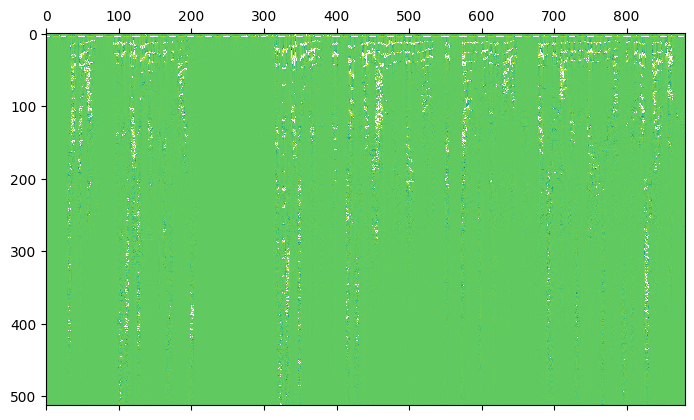

<Figure size 1200x400 with 0 Axes>

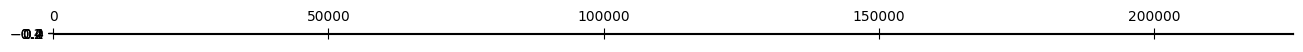

In [112]:
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio

def create_audio():
    waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = dataset[0]

    display(Audio(waveform.numpy(), rate=sample_rate))

    # Transform

    n_fft = 1024
    hop_length = 256
    n_mels = 64

    mel_transform = T.MelSpectrogram(
        sample_rate=16000,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    # spectrogram = mel_transform(waveform).squeeze(0)
    spectrogram = torch.stft(waveform, n_fft=n_fft, hop_length=hop_length, return_complex=False)
    print(f"HI {spectrogram.shape}")

    print(spectrogram[0,:,:,0].shape)
    plt.figure(figsize=(12,4))
    plt.matshow(torch.log1p(spectrogram[0,:,:,0]))
    print(spectrogram[0][20][0])

    # plt.figure(figsize=(12, 4))
    # plt.title("Spectrogram")
    # plt.imshow(spectrogram, aspect='auto', origin='lower')
    # plt.subplot(1, 3, 2)


    # Inverse Transform

    # mel_inverse = torchaudio.transforms.InverseMelScale(
    #     n_stft=n_fft // 2 + 1,
    #     n_mels=n_mels,
    #     sample_rate=16000
    # ).to(device)

    # griffin_lim = torchaudio.transforms.GriffinLim(
    #     n_fft=n_fft,
    #     hop_length=hop_length
    # ).to(device)

    # inverse = mel_inverse(spectrogram.to(device))
    spec_compl = torch.stft(waveform, n_fft=n_fft, hop_length=hop_length, return_complex=True)
    print(torch.Tensor.type(spec_compl))
    print(f"HI2 {spec_compl.shape}")

    reverted_waveform = torch.istft(spec_compl, n_fft=n_fft, hop_length=hop_length)
    plt.figure(figsize=(12,4))
    plt.matshow(torch.log1p(reverted_waveform))

    # plt.figure(figsize=(12,4))
    # plt.matshow(torch.log1p(inverse).cpu())

    # print(inverse.shape)

    # reverted_waveform = griffin_lim(inverse).cpu()

    display(Audio(reverted_waveform.numpy(), rate=sample_rate))

create_audio()


In [ ]:
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio

sample_rate = 16000
n_fft = 1024
hop_length = 256

mix_batch, tgt_batch = next(iter(test_loader))
mix_example = mix_batch[0].unsqueeze(0).to(device)
target_example = tgt_batch[0].to(device)

display(Audio(target_example.numpy(), rate=sample_rate))


model.eval()
with torch.no_grad():
    pred_spec = model(mix_example)[0]  # [n_mels, T]

reverted_waveform = torch.istft(pred_spec, n_fft=n_fft, hop_length=hop_length)

display(Audio(reverted_waveform.numpy(), rate=sample_rate))



In [29]:
'''
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio

# === Parameters (keep these in sync with your training) ===
sample_rate = 16000
n_fft = 1024
hop_length = 256
n_mels = 64

# === Transforms ===
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
).to(device)

mel_inverse = torchaudio.transforms.InverseMelScale(
    n_stft=n_fft // 2 + 1,
    n_mels=n_mels,
    sample_rate=sample_rate
).to(device)

griffin_lim = torchaudio.transforms.GriffinLim(
    n_fft=n_fft,
    hop_length=hop_length
).to(device)

# === Get one example from the test_loader ===
mix_batch, tgt_batch = next(iter(test_loader))
mix_example = mix_batch[0].unsqueeze(0).to(device)   # [1, n_mels, T]
target_example = tgt_batch[0].to(device)             # [n_mels, T]

# === Run through model ===
model.eval()
with torch.no_grad():
    pred_spec = model(mix_example)[0]  # [n_mels, T]

# === Convert to waveform ===
# Inverse Mel to Linear
pred_linear = mel_inverse(pred_spec)
tgt_linear = mel_inverse(target_example)
mix_linear = mel_inverse(mix_example[0])

# Griffin-Lim: reconstruct waveform (must be on CPU)
pred_waveform = griffin_lim(pred_linear).cpu()
tgt_waveform = griffin_lim(tgt_linear).cpu()
mix_waveform = griffin_lim(mix_linear).cpu()

# === Playback ===
print("🔊 Predicted isolated voice:")
display(Audio(pred_waveform.numpy(), rate=sample_rate))

print("🎧 Ground truth isolated voice:")
display(Audio(tgt_waveform.numpy(), rate=sample_rate))

print("🎙️ Original mixture:")
display(Audio(mix_waveform.numpy(), rate=sample_rate))
'''

🔊 Predicted isolated voice:


🎧 Ground truth isolated voice:


🎙️ Original mixture:


# Designing Computational Experiments

Helper Functions

In [ ]:
pip install scipy sounddevice

In [ ]:
import sounddevice as sd
import numpy as np

# play_wav_file("path/to/your/audio.wav")
def play_audio(audio, sample_rate=44100):
    """
    Plays an audio sample.

    Parameters:
    - audio (numpy.ndarray): The audio data. Can be mono (1D) or stereo (2D).
    - sample_rate (int): Sampling rate in Hz (default: 44100).
    """
    if not isinstance(audio, np.ndarray):
        raise ValueError("Audio must be a NumPy array.")

    if audio.ndim > 2 or (audio.ndim == 2 and audio.shape[1] > 2):
        raise ValueError("Audio must be mono or stereo.")

    sd.play(audio, samplerate=sample_rate)
    sd.wait()  # Wait until audio playback is finished


import matplotlib.pyplot as plt

# visualize_wav("path/to/your/audio.wav")
def visualize_wav(filepath, show_spectrogram=True):
    """
    Visualizes the waveform (and optionally spectrogram) of a WAV file.

    Parameters:
    - filepath (str): Path to the WAV file.
    - show_spectrogram (bool): Whether to show the spectrogram below the waveform.
    """
    # Load audio
    data, samplerate = sf.read(filepath)
    duration = len(data) / samplerate
    time = np.linspace(0, duration, num=len(data))

    # Set up plot
    fig, axs = plt.subplots(2 if show_spectrogram else 1, 1, figsize=(12, 6), sharex=True)

    if not isinstance(axs, np.ndarray):
        axs = [axs]  # ensure axs is always a list for consistency

    # Plot waveform
    axs[0].plot(time, data)
    axs[0].set_title('Waveform')
    axs[0].set_ylabel('Amplitude')
    axs[0].grid(True)

    # Optional: Plot spectrogram
    if show_spectrogram:
        axs[1].specgram(data[:, 0] if data.ndim > 1 else data, Fs=samplerate, NFFT=1024, noverlap=512)
        axs[1].set_title('Spectrogram')
        axs[1].set_ylabel('Frequency [Hz]')
        axs[1].set_xlabel('Time [s]')

    plt.tight_layout()
    plt.show()

"""
Example:

# Load audio files
speaker1, sr = librosa.load("speaker1.wav", sr=None)
speaker2, _ = librosa.load("speaker2.wav", sr=None)

# Mix with speaker2 at 4x the volume of speaker1
mixed, s1_adj, s2_adj = adjust_loudness_mix(speaker1, speaker2, loudness_ratio=4.0)

# Save to disk
librosa.output.write_wav("mixed.wav", mixed, sr)
"""
def adjust_loudness_mix(speaker1_wave, speaker2_wave, loudness_ratio):
    """
    Adjusts the loudness of speaker2 relative to speaker1.

    Parameters:
        speaker1_wave (np.ndarray): Audio waveform of speaker 1.
        speaker2_wave (np.ndarray): Audio waveform of speaker 2.
        loudness_ratio (float): Factor to scale speaker2's amplitude.
                                 e.g., 2.0 means speaker2 is twice as loud as speaker1.

    Returns:
        mixed_wave (np.ndarray): The resulting mixture of the two speakers.
        adjusted_speaker2 (np.ndarray): The scaled version of speaker2_wave.
    """
    # Match length if needed
    min_len = min(len(speaker1_wave), len(speaker2_wave))
    speaker1_wave = speaker1_wave[:min_len]
    speaker2_wave = speaker2_wave[:min_len]

    # Apply loudness adjustment to speaker2
    adjusted_speaker2 = speaker2_wave * loudness_ratio

    # Mix the two signals
    mixed_wave = speaker1_wave + adjusted_speaker2

    # Optional: Normalize to avoid clipping
    max_val = np.max(np.abs(mixed_wave))
    if max_val > 1.0:
        mixed_wave = mixed_wave / max_val
        adjusted_speaker2 = adjusted_speaker2 / max_val
        speaker1_wave = speaker1_wave / max_val

    return mixed_wave, speaker1_wave, adjusted_speaker2

ModuleNotFoundError: No module named 'sounddevice'

# Nate does some delicious testing here

In [ ]:
# dataset = torchaudio.datasets.LIBRISPEECH(root="./data", url="train-clean-100", download=False)
waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id = dataset[0]

play_audio(waveform)

NameError: name 'play_audio' is not defined

**Experiment 1 - adjust loudness of target input and compare loss**

Goal: Assess how robust the model is when one speaker is significantly louder.

Design:

For each mixed sample, systematically vary the amplitude of one speaker:

 - Ratios: 1:1 (baseline), 2:1, 4:1, 8:1

Evaluate performance degradation or adaptation.

Hypotheses:

MSE may degrade linearly with imbalance.

CTC might maintain higher robustness if sequences are still distinguishable.

Experiment 2 - adjust loudness of background noise and compare loss (I think this may combine with experiments 1 and 4)

**Experiment 3 - compare efficiency on different languages**

Goal: Evaluate performance when one or both speakers speak a non-English language.

Design:

Use mixtures of English-English, English-Other (e.g., English-Spanish), and Other-Other.

Focus on tonal vs non-tonal languages for diversity.

Optional:

Augment training data with multilingual samples.

Try language embeddings if you're using a deeper pipeline.

Analysis:

Does the model performance degrade with unfamiliar phonetic structures?

Does it favor English content due to training bias?



**Experiment 4 - add non-human background noise and compare loss**

Goal: Evaluate robustness to noise interference (e.g., cafe noise, car engines, music).

Design:

Add non-human noise at varying SNRs (e.g., 30 dB, 20 dB, 10 dB).

Use both stationary and non-stationary noise.

Compare:

Performance with and without noise-aware preprocessing.

Try noise suppression front-ends or data augmentation with noise.

**Extra Experiments You Could Add**

Speaker permutation invariance: Does the model consistently output the same speaker when order varies?

Speaker gender and pitch: Investigate separation accuracy across gender combinations or pitch similarity.

Temporal length variation: Does it work on long conversations vs short utterances?

Window size sensitivity: Test how performance changes with different input chunk sizes.